In [1]:
import matplotlib.pyplot as plt
import numpy as np

from cells import Points
from obstacles import CircularObstacles

%matplotlib ipympl

# Session 2: Channels models

In the previous session, we introduced the concept of Monte Carlo simulations to model the channel,
which can be categorized as a *stochastic* model.

Other very popular model types are *empirical* models and *exact* models.
The former are mostly based on measurements and often dedicate to one kind of environment (e.g.: urban, sub-urban or indoor). The latter, tries a simulate the wave propagation using very accurate models, often at a higher computational cost. Ray Tracing (RT) is one of those *exact* method.

RT is a widely used method, used in sound acoustics, telecommunications, or optical lenses manufacturing, to simulate the channel between points, while accounting for the surrounding geometries.

In this session, you will have to implement and compare the 
[COST Hata model](https://en.wikipedia.org/wiki/COST_Hata_model) with a basic Ray Tracing model. For more details, the COST model is defined in the
[COST 231 final report, Chpt. 4, Sec. 4.4.1, Eq. 4.4.3. page 135](http://www.lx.it.pt/cost231/final_report.htm).

> NOTE: contrarily to the previous one, this session will not include a lot of code.
> Still, you will most likely need to import some code from session 1.

## Scenario of interest

Below, you can observe the very basic scenario we will use for this session.
In the following, obstacles are represented by cylindrical structures, show by circular shapes
in 2D. Emitting and receiving antennas are 2D points.

Points are generated such that their are not contained within nay of the obstacles present
in the scene. This, of course, will change the received power distribution.

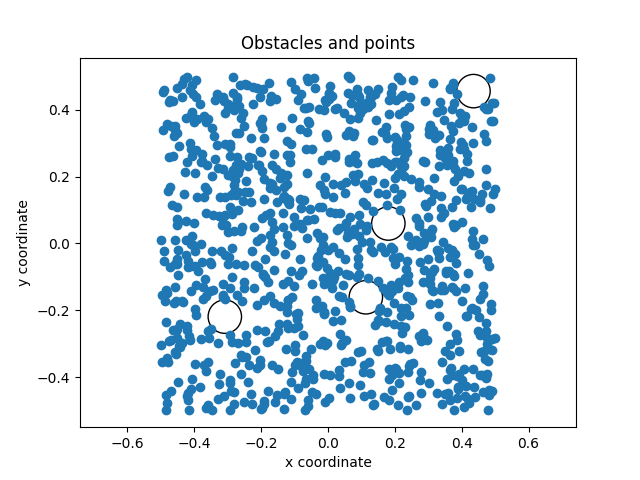

In [10]:
plt.figure()

obstacles = CircularObstacles.generate(4, radius=0.05)
obstacles.draw()

points = Points.generate(1000)
cond = obstacles.contains(points)
points = points[~cond]  # We only keep points that are not inside obstacles
points.draw()

plt.title("Obstacles and points")
plt.xlabel("x coordinate")
plt.ylabel("y coordinate")
plt.axis("equal")
plt.show()

## 2.A: Power distribution and obstacles density

In the following two cells, we ask you to:

1. **plot the power distribution** for different numbers of obstacles `n`, `n = 0` being an obstacle-free scenario. *Note that obstacle may overlap!*
2. **plot the obstacles density** as of function of the number of obstacles, for different values of `radius` in `CircularObstacles.generate`.

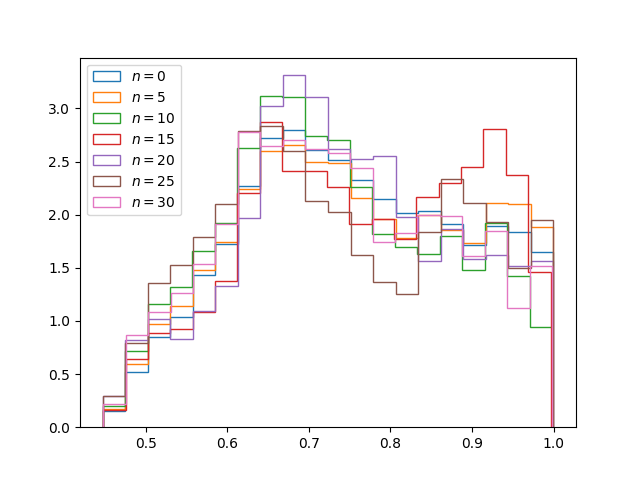

In [3]:
# TODO: Complete this cell to plot the power distribution

plt.figure()

def received_power(
    points: Points
) -> np.ndarray:
    """
    Dummy function, should use the one from session 1.
    """
    r = np.linalg.norm(points.array, axis=1)
    return (1.0 + r**2) ** (-2.0)

# NOTE:
# for this, you might want to use density=True and histtype="step"
# options with plt.hist

# :START-REMOVE:
points = Points.generate(10000)

ns = np.arange(0, 31, 5)
for n in ns:
    obstacles = CircularObstacles.generate(n, radius=0.1)
    cond = obstacles.contains(points)
    p = received_power(points[~cond])
    plt.hist(p, bins=20, density=True, histtype="step", label=f"$n={n}$")

plt.legend()
# :END-REMOVE:
plt.show()

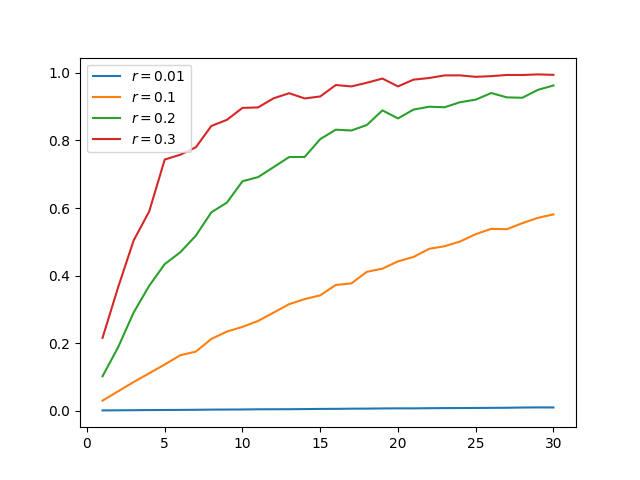

In [4]:
# TODO: Complete this cell to plot obstacles density

plt.figure()

# :START-REMOVE:
points = Points.generate(10000)

ns = np.arange(1, 31)
repeat = 20
for radius in [0.01, 0.1, 0.2, 0.3]:
    d = []
    for n in ns:
        tmp = []
        for _ in range(repeat):
            obstacles = CircularObstacles.generate(n, radius=radius)
            tmp.append(obstacles.contains(points))
        d.append(np.mean(tmp))
    plt.plot(ns, d, label=f"$r={radius}$")

plt.legend()
# :END-REMOVE:
plt.show()

As you can see from the results above, we still do not account
for potential line of sight (LOS) obstruction by obstacles,
also called *path shadowing*.

## 2.B: Simple path shadowing model

A very simple way to model the path shadowing is to add a random,
usually zero-center, contribution, $S$ to the path loss function:

$$P(d) = L(d) + S,$$

where $L(d)$ is the path loss with respect to the distance.

> **NOTE:** the terms *path loss* and *received power* are usually intervertible, since
> one can easily obtain the first from the second, and vice-versa. 

Below, you need to **implement** some path shadowing loss of your choice.
For a first try, we recommend using a normal distribution with zero mean. The next models will help
you fine tune this one.

In [5]:
# TODO: Implement these functions

def path_shadowing_loss(path_loss: np.ndarray) -> np.ndarray:
    """
    Add a random shadowing to the path loss L(d).

    NOTE: you add any number of arguments to this function, is needed.
    """
    return path_loss + 0.0  # Change me

## 2.C: COST Hata model

A second approach to this problem is to use more specific models, e.g., the COST Hata model,
to better represent the impact of the current scenario on your path loss.

Those models are usually obtained after several measurements compains, and aim to represent the
average behavior of a given scenario.

In the next cell, **implement** the COST Hata model.

In [6]:
# TODO: Implement these functions


def alpha(f: float, h_R: float) -> float:
    """
    Returns the height correction factor.
    """
    return 0.0  # Change me


def COST_Hata_loss(
    f: float, h_B: float, d: np.ndarray, h_R: float, C_m: float
) -> np.ndarray:
    """
    Returns the median path loss (in dB).
    """
    alpha(h_R, f)
    return np.zeros_like(d)  # Change me

## 2.D: Ray Tracing

Finally, we propose you to implement a two-rays RT model.

As its name implies, RT consists in representating EM waves as ray paths, and
tracing all possible paths from two points, usually TX and RX antennas. Then, we can compute the EM fields for each path separately, and add them altogether.

With this, RT has the major advantage of taking into account the real description of
the scene, and not some average situation. On the other hand, it needs a precise description
of the environment, and tracing all ray paths can be quite time consuming<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1).

In this session, we will implement a basic RT model that can:

+ compute LOS and 1-reflection paths (see `reflection_point_from_los`);
+ and attenuation paths that encounter one or more obstacles
  (see `line_segment_circle_intersection_depth`).

For the path obstruction, we will assume an exponential power decay
with respect with the depth $d$:

$$P(d) = e^{-\alpha \cdot d} P_\text{LOS},$$

where $P_\text{LOS}$ is the power receiver in a LOS case (no obstruction), and
$\alpha$ is some parameter you will need to estimate.

Crossing multiple obstacles is then equivalent to crossing one large obstacle whose's
depth is the sum of each obstacle' depth.

The aforementioned functions are implemented in the next cell.
Please read them carefully.

<a name="cite_note-1"></a>[1.](#cite_ref-1) Actually, tracing all paths would take an infinite amount of time and, in practive, we limit to a maximum number of *bounces*. Still, the complexity grows exponentially with this number.

In [7]:
def reflection_point_from_los(
    x0: float, y0: float, z0: float, x1: float, y1: float, z1: float
) -> np.ndarray:
    """
    Compute the reflection point on the plane z = 0,
    from a given LOS path,
    and return it [x, y] coordinates.
    """
    r= z0 / (z0 + z1)
    dx = x1 - x0
    dy = y1 - y0
    return np.array([x0 + r * dx, y0 + r * dy])

def line_segment_circle_intersection_depth(
    x0: float, y0: float, x1: float, y1: float, xc: float, yc: float, rc: float
) -> float:
    """
    Return the length of the intersection section segment between a
    line segment and a circle.

    This algorirthm computes the distance between the two intersection
    points, using the algorithm detailed in:
    https://mathworld.wolfram.com/Circle-LineIntersection.html

    The depth is always between 0 and xc, the circle radius.
    """
    # Set the circle center to (0, 0)
    x0 = x0 - xc; y0 = y0 - yc
    x1 = x1 - xc; y1 = y1 - yc
    dx = x1 - x0
    dy = y1 - y0
    dr = np.sqrt(dx * dx + dy * dy)
    dr2 = dr * dr
    D = x0 * y1 - x1 * y0
    delta = rc * rc * dr2 - D * D
    delta = np.clip(delta, a_min=0.0, a_max=None)  # Avoir negative square roots
    sdelta = np.sqrt(delta)
    dsx = 2 * dx * sdelta / dr2
    dsy = 2 * dy * sdelta / dr2
    dot = dx * (-x0) + dy * (-y0)  # Dot product between line segment and vector
    # from (x0, y0) to circle's center (0, 0)
    circle_between_points = 0 <= dot <= dr2

    depth = np.sqrt(dsx * dsx + dsy * dsy)

    return np.where(circle_between_points, depth, 0.0)

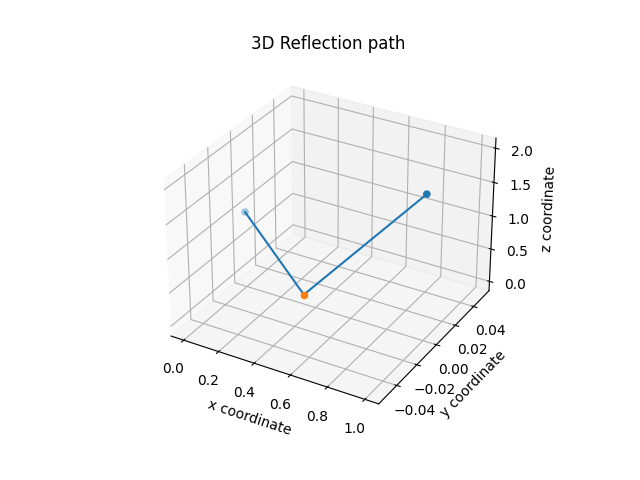

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x0, y0, z0 = 0.0, 0.0, 1.0
x1, y1, z1 = 1.0, 0.0, 2.0
xr, yr = reflection_point_from_los(x0, y0, z0, x1, y1, z1)

ax.plot([x0, xr, x1], [y0, yr, y1], [z0, 0.0, z1])
ax.scatter([x0, x1], [y0, y1], [z0, z1])
ax.scatter([xr], [yr], [0.0])

plt.title(f"3D Reflection path")
ax.set_xlabel("x coordinate")
ax.set_ylabel("y coordinate")
ax.set_zlabel("z coordinate")
plt.show()

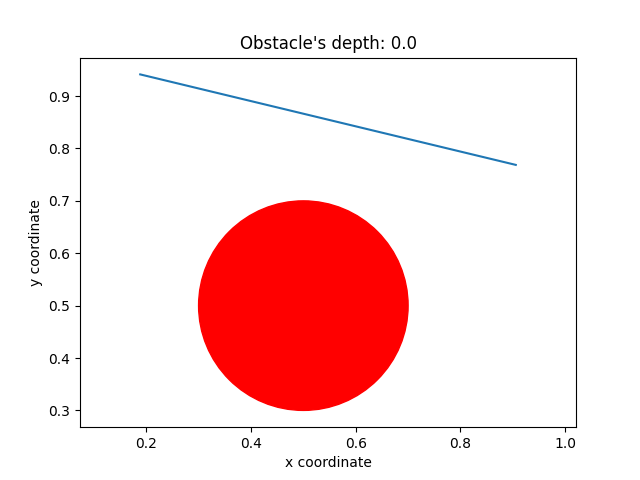

In [9]:
# Run this cell multiple times to see different configuration, and
# the computed intersection depth

fig, ax = plt.subplots()

p0, p1 = np.random.rand(2, 2)
center = np.array([0.5, 0.5])
rc = .2

d = line_segment_circle_intersection_depth(*p0, *p1, *center, rc)

ax.add_patch(plt.Circle(center, rc, color="r"))
ax.plot([p0[0], p1[0]], [p0[1], p1[1]])

plt.title(f"Obstacle's depth: {d:.3}")
plt.xlabel("x coordinate")
plt.ylabel("y coordinate")
ax.axis("equal")
plt.show()

## 2.E: Comparing models

Once you have implemented the models presented above,
you are asked to compare them, on different metrics of your choice.

If you have no idea, start with the power distribution, and move
to more complicated ones once you feel ready.

## 2.F: What's next?

Here, we limited ourselve to simple models and simple scenarios.
However, it is worth exploring a lot more:

+ What happens if you have multiple cells, i.e., more than one emitting antenna?
+ How does the coverage evolve with the obstacles' density?
+ And so on...